## Homework 4

Use this notebook as a starter

In [316]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [317]:
import warnings
warnings.filterwarnings('ignore')

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [318]:
dataset_url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv"
path_to_data = "../../datasets/week_4_creditscoring.csv"
!wget $dataset_url -O $path_to_data

--2021-09-30 15:16:37--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘../../datasets/week_4_creditscoring.csv’

../../datasets/week 100%[===================>] 178.21K  --.-KB/s    in 0.07s   

2021-09-30 15:16:37 (2.44 MB/s) - ‘../../datasets/week_4_creditscoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [319]:
df = pd.read_csv(path_to_data)
df.columns = df.columns.str.lower()

In [320]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Some of the features are encoded as numbers. Use the following code to de-code them:

In [321]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [322]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [323]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [324]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [325]:
df.columns

Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
       'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'],
      dtype='object')

## Your code

What are the categorical variables? What are the numerical?

In [326]:
categorical = ['home','marital','records','job']
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 
             'debt', 'amount', 'price', 'default']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [327]:
from sklearn.model_selection import train_test_split

In [328]:
datasize = len(df)
print(datasize)
val_size = datasize*.20
val_size

4454


890.8000000000001

In [329]:
full_train, test_df = train_test_split(df, random_state=1, test_size=.20)

val_set_size = round(val_size / len(full_train),2)
print(f"Val set size:{val_set_size}")

train_df, val_df  = train_test_split(full_train, random_state=1, test_size=val_set_size)

Val set size:0.25


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [330]:
from sklearn.metrics import roc_auc_score

In [331]:
aucs = {} 
for num_var in ['seniority', 'time','income', 'debt']:
    aucs[num_var] = roc_auc_score(train_df.default, train_df[num_var])

In [332]:
aucs

{'seniority': 0.2906221375508058,
 'time': 0.5608662489595051,
 'income': 0.31799333386736695,
 'debt': 0.49521703242164505}

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [333]:
y_train = train_df['default']
y_test = test_df['default']
y_val = val_df['default']

del train_df['default']
del test_df['default']
del val_df['default']

In [334]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [335]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [336]:
def train(df, target, c=1.0): 
    
    train_dict = df.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    
    X_train =  dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, target)
    
    return dv, model

In [337]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']
dv, model = train(train_df[features], y_train)

In [338]:
val_dict = val_df[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Get predictions 
y_pred = model.predict_proba(X_val)[:,1]

In [339]:
y_pred[:5]

array([0.19686431, 0.11756687, 0.26981906, 0.12327234, 0.04141657])

In [340]:
auc = roc_auc_score(y_val, y_pred)
round(auc,3)

0.812

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- [ ] 0.512
- [ ] 0.612
- [ ] 0.712
- [x] 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [341]:
thresholds = np.linspace(0,1,101)
scores = []

In [342]:
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    
    scores.append((t, recall, precision))

In [343]:
scores[:5]

[(0.0, 1.0, 0.2760942760942761),
 (0.01, 1.0, 0.2792281498297389),
 (0.02, 0.991869918699187, 0.2847141190198366),
 (0.03, 0.983739837398374, 0.2898203592814371),
 (0.04, 0.983739837398374, 0.30062111801242236)]

In [344]:
columns = ['threshold', 'precision','recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,precision,recall
0,0.00,1.00000,0.276094
1,0.01,1.00000,0.279228
2,0.02,0.99187,0.284714
3,0.03,0.98374,0.289820
4,0.04,0.98374,0.300621
...,...,...,...
96,0.96,0.00000,NaN
97,0.97,0.00000,NaN
98,0.98,0.00000,NaN
99,0.99,0.00000,NaN


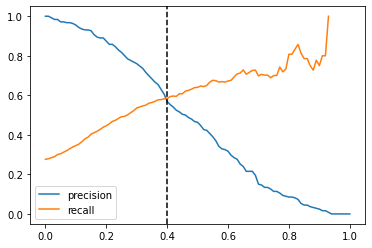

In [345]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.axvline(x=0.4,color="black", linestyle="--")
plt.legend()

At which threshold precision and recall curves intersect?

* [ ] 0.2
* [x] 0.4
* [ ] 0.6
* [ ] 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [346]:
f1s = {}

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    
    f1s[t] = 2 * (precision * recall) / (precision + recall)

In [347]:
max(f1s, key=f1s.get)

0.3

At which threshold F1 is maximal?

- [ ] 0.1
- [x] 0.3
- [ ] 0.5
- [ ] 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [348]:
def predict(df,dv,model):
    dicts = df.to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [349]:
from sklearn.model_selection import KFold

In [350]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=1)

In [351]:
def calculate_auc(c=1.0):
    aucs = []
    for train_idx, val_idx in kfolds.split(full_train):
        # Get the new sets for training and validation
        train_df = full_train.iloc[train_idx]
        val_df = full_train.iloc[val_idx]

        train_df = train_df.reset_index(drop=True)
        val_df = val_df.reset_index(drop=True)

        # Get the target values for train and 
        y_train = train_df.default.values
        y_val = val_df.default.values

        del train_df['default']
        del val_df['default']

        dv, model = train(train_df[features], y_train,c=c)
        y_pred = predict(val_df[features], dv,model)

        # Calculate AUC score
        score = roc_auc_score(y_val, y_pred)
        aucs.append(round(score,3))
    return aucs

In [352]:
aucs = calculate_auc() 
round(np.std(aucs),3)

0.014

How large is standard devidation of the scores across different folds?

- [ ] 0.001
- [x] 0.014
- [ ] 0.09
- [ ] 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [361]:
means = {}
for c in [0.01, 0.1, 1, 10]:
    aucs = calculate_auc(c) 
    means[c] = {'mean': round(np.mean(aucs),3), 'std': round(np.std(aucs),3)}

In [362]:
means

{0.01: {'mean': 0.809, 'std': 0.013},
 0.1: {'mean': 0.813, 'std': 0.014},
 1: {'mean': 0.812, 'std': 0.014},
 10: {'mean': 0.814, 'std': 0.015}}

Which C leads to the best mean score?

- [ ] 0.01
- [ ] 0.1
- [ ] 1
- [x] 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.